In [61]:
#Read dsf with foliair deficit > 50
import geopandas as gpd

#Read dsf
dsf = gpd.read_parquet('/Users/arthurcalvi/Data/Disturbances_maps/DSF/RSSDF_deficitfoliaire_g_50_EPSG32631.parquet')
dsf.reset_index(inplace=True, drop=True)
assert dsf.crs == 'epsg:32631'

# Creation of the dict to store the aoi

In [72]:
#Parameters 
import os
dir_ = '/Users/arthurcalvi/Data/sampling/france-dsf'
os.makedirs(dir_, exist_ok=True)
n = 20
col_region = 'name'
name_dict = 'dict_aoi_{}.pkl'.format(os.path.basename(dir_))

print('Nbr of aoi to download:', n)

Nbr of aoi to download: 20


In [73]:
import random 
from shapely.geometry import Point
from utils import compute_IoU
from tqdm import tqdm

dict_aoi = {}
list_aoi = []
dsf_ = dsf.copy()
for i in tqdm(range(n)):
    
    
    random_row = random.choice(dsf_.index.tolist())

    row = dsf_.loc[random_row]

    #get 10x10km aoi
    aoi = Point(row.geometry.centroid.x, row.geometry.centroid.y).buffer(4750, cap_style=3)

    #key
    key = '-'.join([row.dateobs.date().strftime('%Y%m%d'), str(row['plot'])])

    list_aoi.append((row['plot'], row.dateobs.date(), aoi))


    #drop row
    dsf_.drop(index=random_row, inplace=True)

#save gdf
gdf = gpd.GeoDataFrame(list_aoi, columns=['plot', 'date', 'geometry'], crs='epsg:32631')
gdf.date = pd.to_datetime(gdf.date)
gdf['year'] = gdf.date.dt.year

100%|██████████| 20/20 [00:00<00:00, 332.96it/s]


(144436.05659576002, 1032109.6269383822, 4641304.098761812, 5518164.850863509)

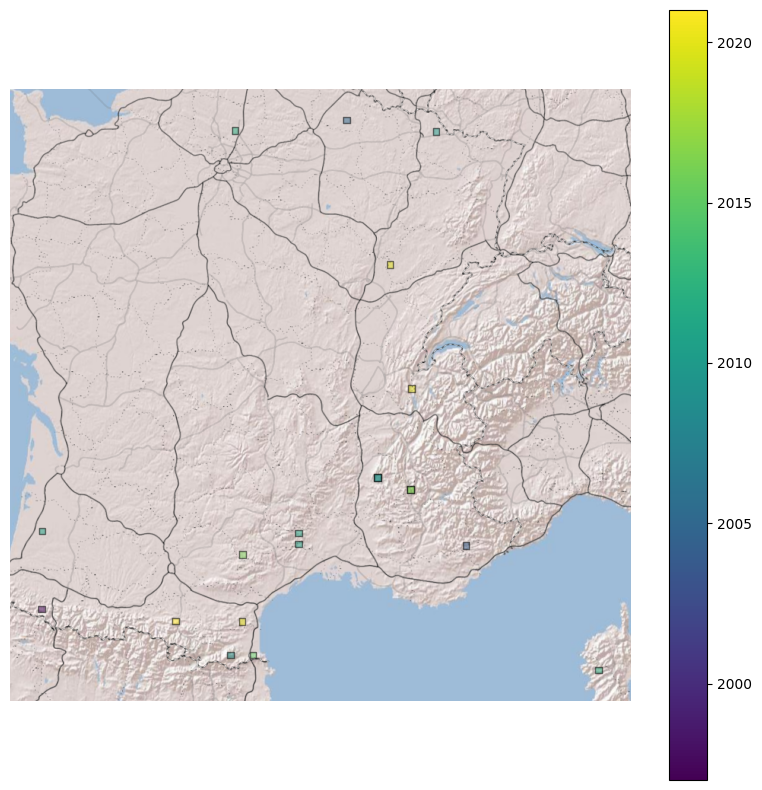

In [74]:
#plot sampling
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

gdf.plot(ax=ax, column='year', edgecolor='k', alpha=0.5, legend=True, cmap='viridis')

#add basemap
import contextily as ctx
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.Esri.WorldShadedRelief, attribution=False)
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.Stamen.TonerLines, attribution=False)

#axis off
ax.axis('off')


In [76]:
gdf.sort_values(by='year', inplace=True)


,plot,date,geometry,year
19,2023,1997-07-15,"POLYGON ((194284.855 4777963.182, 194284.855 4...",1997
9,1935,2004-08-03,"POLYGON ((802125.664 4868857.559, 802125.664 4...",2004
2,1670,2005-07-20,"POLYGON ((675093.402 4966071.191, 675093.402 4...",2005
0,251,2005-07-01,"POLYGON ((631406.916 5478307.544, 631406.916 5...",2005
14,2114,2009-08-31,"POLYGON ((465211.810 4712346.694, 465211.810 4...",2009
5,305,2010-07-23,"POLYGON ((759173.727 5461373.215, 759173.727 5...",2010
13,1670,2011-08-31,"POLYGON ((675093.402 4966071.191, 675093.402 4...",2011
10,1828,2011-08-29,"POLYGON ((562495.223 4887160.750, 562495.223 4...",2011
18,1874,2011-07-19,"POLYGON ((562357.327 4871186.676, 562357.327 4...",2011
11,1722,2011-08-29,"POLYGON ((194948.705 4889987.396, 194948.705 4...",2011


In [77]:
gdf.to_parquet(os.path.join(dir_, 'sampling_aoi_{}_20.parquet'.format(os.path.basename(dir_))))